## Pocesamiento de data

In [1]:
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import random

In [2]:
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/ML_P4/train.csv'
df = pd.read_csv(path)
df.info()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  25000 non-null  object
 1   label    25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [3]:
random_indices = random.sample(range(len(df)), 10)

for index in random_indices:
  print(df['message'][index])
  print()

William Hurt scuba diving scientist??? US agents running the investigation abroad? The sick contaminated man kicking butt after falling 20 feet on his back and running away? Sniper missing and not killing Hurt (just wounding him) but the second "kill" shot is dead on ? Waste of time. To compare this to falling down as other reviewers did is ridiculous. Oh and by the end of the movie they decide to start wearing gloves on their hands except for the "evil" agent and Hurt decides to kill him by giving him the "virus handshake". What? BTW...when did IMDb require 10 lines of text? I'm just babbling here. Doesn't this just dillute the content of reviews if you are required to have x amount of lines?

Where to start... If this movie had been a dark comedy, I would say it was FANNN-TASTIC! Unfortunately for me, and anyone else with free time and a buck to spare (mind you that was the price I paid, got it from Wal-Mart), this movie was meant to be a thriller. The only THRILL I got was watching 

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocesamiento

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import tensorflow as tf

In [6]:

def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [re.sub(r'\@\w+|\#', '', token) for token in tokens]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)
    return text

In [7]:
# Aplicamos
df['processed_text'] = df['message'].apply(preprocess)
df['processed_text'] = df['processed_text'].replace('', np.nan)
df = df.dropna(subset=['processed_text'])

df['label'] = df['label'].map({'neg': 0, 'pos': 1})

In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Train Word2Vec
sentences = [text.split() for text in df['processed_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

## Modelo: RNN

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


In [10]:

batch_size = 32
if not isinstance(X_train_pad, torch.Tensor):
    X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
if not isinstance(X_test_pad, torch.Tensor):
    X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
# RNN
class RNNModel(nn.Module):
    def __init__(self, layers, vocab_size, embed_dim, hidden_dim, embed_matrix, output_dim=1):
        super(RNNModel, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.layers = layers
        self.vocab_size = vocab_size

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embed_matrix), freeze=True)

        # RNN layer
        self.rnn = nn.RNN(input_size=embed_dim,
                          hidden_size=self.hidden_dim,
                          num_layers=layers,
                          batch_first=True)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(rnn_out)
        out = self.fc(out)

        sig_out = self.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros((self.layers, batch_size, self.hidden_dim)).to(device)
        return hidden


In [12]:
def train_rnn(model, train_loader, criterion, optimizer, device, batch_size, num_epochs):
    model.train()
    for epoch in range(num_epochs):

        hidden = model.init_hidden(batch_size)

        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            hidden = hidden.detach()
            outputs, hidden = model(inputs, hidden)

            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

In [13]:

embed_dim = 100
hidden_dim = 64
layers = 2  # Capas del RNN
output_dim = 1
num_epochs = 10
learning_rate = 0.001

model = RNNModel(layers, vocab_size, embed_dim, hidden_dim, embedding_matrix, output_dim).to(device)

# Criterio de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_rnn(model, train_loader, criterion, optimizer, device, batch_size, num_epochs)


Epoch 1/10, Loss: 0.6703732687950135
Epoch 2/10, Loss: 0.6737924294471741
Epoch 3/10, Loss: 0.6868903817176819
Epoch 4/10, Loss: 0.6812847832679748
Epoch 5/10, Loss: 0.6745751032829285
Epoch 6/10, Loss: 0.6675351883888244
Epoch 7/10, Loss: 0.661448567199707
Epoch 8/10, Loss: 0.6603928182125092
Epoch 9/10, Loss: 0.6755221129894257
Epoch 10/10, Loss: 0.6690156358718872


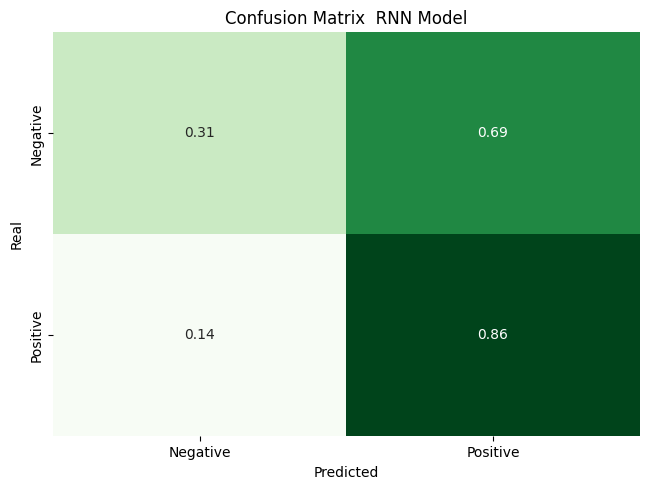

F1 Score: 0.6821295143212951
Precision: 0.5661498708010336
Recall: 0.8578700078308535
              precision    recall  f1-score   support

         0.0       0.68      0.31      0.43      2446
         1.0       0.57      0.86      0.68      2554

    accuracy                           0.59      5000
   macro avg       0.62      0.59      0.56      5000
weighted avg       0.62      0.59      0.56      5000



In [14]:

def evaluate_model(model, valid_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            hidden = model.init_hidden(inputs.size(0))
            outputs, hidden = model(inputs, hidden)
            y_pred.extend((outputs.squeeze() > 0.5).float().cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    return y_test, y_pred


def matriz_confusion(y_test, y_pred, Tipo):
    matrix = confusion_matrix(y_test, y_pred)
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Negative", 'Positive'], columns=["Negative", 'Positive'])
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + Tipo)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()


def calculate_metrics(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# Evalúa el modelo
y_test_eval, y_pred_eval = evaluate_model(model, valid_loader, device)

matriz_confusion(y_test_eval, y_pred_eval, " RNN Model")

calculate_metrics(y_test_eval, y_pred_eval)

print(classification_report(y_test_eval, y_pred_eval))

## Predicción usando el modelo cargado


In [15]:

def predict_text(text, model, embedding_matrix, tokenizer, device, max_length=300):

    word_indices = tokenizer.texts_to_sequences([text])

    pad_sequence = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(word_indices[0][:max_length], dtype=torch.long)],
        batch_first=True, padding_value=0)

    embed_sequence = torch.tensor([
        embedding_matrix[word_idx] if word_idx < len(embedding_matrix) else np.zeros(100)
        for word_idx in pad_sequence[0]
    ], dtype=torch.float32)

    embed_sequence = embed_sequence.unsqueeze(0).to(device)

    batch_size = 1
    h = model.init_hidden(batch_size).to(device)

    model.eval()
    with torch.no_grad():
        pad_sequence = pad_sequence.type(torch.long).to(device)
        output, h = model(pad_sequence, h)
    return output.item()

def predict_and_display(df, model, embedding_matrix, tokenizer, device):
    predicted_sentiments = []

    for idx, row in df.iterrows():
        review = row['message']

        predicted_sentiment = predict_text(review, model, embedding_matrix, tokenizer, device)

        predicted_sentiments.append(predicted_sentiment)

    df['predicted_sentiment'] = ['pos' if pred > 0.45 else 'neg' for pred in predicted_sentiments]

    print("DataFrame con predicciones:")
    print(df.head())
    print()


In [16]:
path1 = '/content/drive/MyDrive/ML_P4/test.csv'

df_test = pd.read_csv(path1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predict_and_display(df_test, model, embedding_matrix, tokenizer, device)

<ipython-input-15-3609ae43d701>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  embed_sequence = torch.tensor([


DataFrame con predicciones:
                                             message predicted_sentiment
0  Acclaimed Argentine horror director Emilio Vie...                 pos
1  I don't know if it's fair for me to review thi...                 pos
2  The only good thing about Persepolis is the sh...                 pos
3  I completely forgot that I'd seen this within ...                 pos
4  B. Kennedy tried to make a sequel by exaggerat...                 pos



In [17]:
df_test["ids"] = range(len(df_test))

df_test.rename(columns={"predicted_sentiment": "label"}, inplace=True)

df_test.to_csv("mi_archivo.csv", columns=["ids", "label"], index=False)